In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

/home/lovely/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2038649757524852173, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1399980032
 locality {
   bus_id: 1
 }
 incarnation: 12062647249508767770
 physical_device_desc: "device: 0, name: GeForce 940MX, pci bus id: 0000:01:00.0, compute capability: 5.0"]

In [2]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from python_speech_features import base as speech
%matplotlib inline

Using TensorFlow backend.


In [137]:
from PIL import Image

In [24]:
import tensorflow as tf

In [31]:
tf.__version__

'1.4.1'

In [32]:
keras.__version__

'2.1.6'

In [122]:
classes = np.array(['angry', 'calm', 'disgust', 'fearful', 'happy', 'sad', 'surprised']) # no neutral
all_mel_cepstral_coefficients = []
all_class_labels = []

path = 'RAVDESS/0_all_speech/'

min_sig_len = 140941
max_sig_len = 253053

winlen = 0.025 # the length of the analysis window in seconds (25 milliseconds)
winstep = 0.01    # the step between successive windows in seconds (10 milliseconds)
preemph = 0.97   # coefficient

nfilt = 40 # ?? the number of filters in the filterbank, default 26.
nfft = 512 * 3 # ?? the FFT size. Default is 512.

numcep = 13 # ?? num of cepstral coefs
ceplifter = 0 # apply a lifter to final cepstral coefficients. 0 is no lifter 22

winfunc = np.hamming # lambda x: np.ones((x,)) # window function

In [125]:
for file in os.listdir(path):
    class_label = file.split('-')[0]
    
    if not 'neutral' in class_label:
    
        signal, samplerate = librosa.core.load(path+file, sr=48000)
        class_label = np.where(classes == class_label)[0][0]
    
        # feature = librosa.feature.mfcc(y=signal, sr=samplerate, n_mfcc=40)
        # mfccs = np.mean(feature.T, axis=0) 
        
        mfccs = speech.mfcc(\
                    signal, \
                    nfft=nfft,\
                    appendEnergy=False,\
                    samplerate=samplerate,\
                    numcep=numcep,\
                    nfilt=nfilt,\
                    winfunc=winfunc
          )
        
        all_mel_cepstral_coefficients.append(mfccs)
        all_class_labels.append(class_label)

/home/lovely/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


In [126]:
all_mel_cepstral_coefficients = np.array(all_mel_cepstral_coefficients) 
all_class_labels = np.array(all_class_labels)

In [127]:
all_mel_cepstral_coefficients.shape, all_class_labels.shape

((1344,), (1344,))

In [128]:
num_of_classes = len(set(all_class_labels)) # 7

In [129]:
np.random.seed(777)

In [ ]:
# TO RGB CONVERSION!!!!!!!!!!!!

In [130]:
def rescale(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return (arr - arr_min) / (arr_max - arr_min)

In [133]:
all_mel_cepstral_coefficients.shape, all_mel_cepstral_coefficients[1].shape

((1344,), (353, 13))

In [139]:
all_mel_cepstral_coefficients[0].shape

(383, 13)

In [140]:
img = Image.fromarray(all_mel_cepstral_coefficients[0], 'RGB')

In [143]:
img.height, img.width

(383, 13)

In [145]:
# img

In [85]:
min_ = np.amax(all_mel_cepstral_coefficients)
max_ = np.amin(all_mel_cepstral_coefficients)
rescaled = (all_mel_cepstral_coefficients - min_) / (max_ - min_)

In [101]:
# X = np.expand_dims(all_mel_cepstral_coefficients, axis=2)
# Y = keras.utils.to_categorical(all_class_labels, num_of_classes)
# Y = all_class_labels[:]
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [102]:
# X = np.expand_dims(rescaled, axis=2)
# Y = keras.utils.to_categorical(all_class_labels, num_of_classes)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [103]:
X_train.shape[:1]

(1008,)

In [104]:
X_test.shape

(336, 40, 1)

In [105]:
X_val = X_test[:250]
Y_val = Y_test[:250]

In [106]:
model = models.Sequential()

model.add(layers.Conv1D(256, 5,padding='same', input_shape=X_train.shape[1:]))
model.add(layers.Activation('relu'))
model.add(layers.Conv1D(128, 5,padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.1))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Conv1D(128, 5,padding='same',))
model.add(layers.Activation('relu'))
model.add(layers.Conv1D(128, 5,padding='same',))
model.add(layers.Activation('relu'))
model.add(layers.Flatten())
model.add(layers.Dense(num_of_classes))
model.add(layers.Activation(tf.nn.softmax))
# model.add(layers.Activation('softmax'))
# model.add(layers.Lambda(lambda x: K.tf.nn.softmax(x)))

In [107]:
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6) # sqd govno
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [117]:
from keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=False
)

In [114]:
# model.summary()

In [113]:
# history = model.fit(X_train, Y_train, batch_size=25, epochs=100, validation_data=(X_val, Y_val))

In [121]:
image_gen.fit(X_train, augment=True)

ValueError: Input to `.fit()` should have rank 4. Got array with shape: (1008, 40, 1)

In [120]:
model.fit_generator(image_gen.flow(X_train, Y_train, batch_size=20),
        steps_per_epoch = X_train.shape[0]//batch_size,
        epochs=epochs,
        verbose=1)

ValueError: ('Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape', (1008, 40, 1))

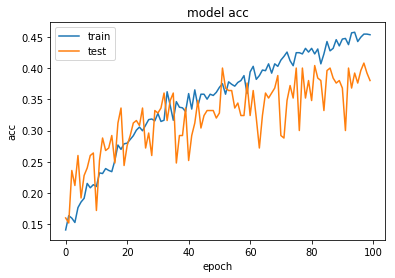

In [112]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

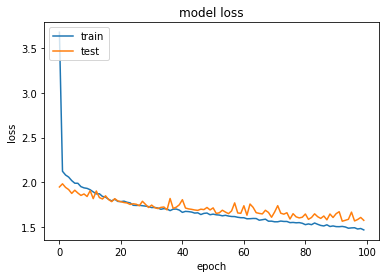

In [110]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
# plt.figure(figsize=(23, 14))
# # librosa.display.specshow(all_mel_cepstral_coefficients[29], x_axis='time',cmap='magma')
# plt.colorbar()
# plt.title('MFCC')
# plt.tight_layout()

# plt.imshow(all_mel_cepstral_coefficients[29], cmap='hot')
# plt.colorbar()
# plt.show()

In [ ]:
# model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])